<a href="https://colab.research.google.com/github/Jakelinecs/Tareas-Machine-Learning/blob/main/N22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

X_train_full = X_train_full.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train_full = X_train_full.astype(np.float64) / 255
X_test = X_test.astype(np.float64) / 255

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot_full = enc.fit_transform(y_train_full[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train_full, y_train_one_hot_full, test_size=0.2, random_state=42
)

_, _, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)


print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_train_one_hot.shape: {y_train_one_hot.shape}")

X_train.shape: (48000, 784)
X_val.shape: (12000, 784)
y_train_one_hot.shape: (48000, 10)


In [4]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [6]:

def tanh(A):
    return np.tanh(A)

def softmax(A):

    C = np.max(A, axis=1, keepdims=True)
    exp_A = np.exp(A - C)
    sum_exp_A = np.sum(exp_A, axis=1, keepdims=True)
    return exp_A / sum_exp_A


def cross_entropy_error(Z3, Y, n_batch):

    L = -np.sum(Y * np.log(Z3 + 1e-7)) / n_batch
    return L


def tanh_grad(A):

    return 1.0 - np.tanh(A)**2

In [8]:
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10,
                 lr=0.01, sigma=0.01, n_epoch=10, batch_size=20, verbose=True):


        self.verbose = verbose
        self.lr = lr
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.sigma = sigma


        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output


        self._initialize_weights()


        self.loss = {'train': [], 'val': []}



    def _initialize_weights(self):

        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.B1 = self.sigma * np.random.randn(self.n_nodes1)


        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = self.sigma * np.random.randn(self.n_nodes2)


        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = self.sigma * np.random.randn(self.n_output)


    def _forward_propagation(self, X):


        self.A1 = X @ self.W1 + self.B1
        self.Z1 = tanh(self.A1)


        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = tanh(self.A2)


        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = softmax(self.A3)

        return self.Z3


    def _backward_propagation(self, X, Y, n_batch):


        dL_dA3 = (self.Z3 - Y) / n_batch


        dL_dB3 = np.sum(dL_dA3, axis=0)


        dL_dW3 = self.Z2.T @ dL_dA3

        dL_dZ2 = dL_dA3 @ self.W3.T


        dL_dA2 = dL_dZ2 * tanh_grad(self.A2)


        dL_dB2 = np.sum(dL_dA2, axis=0)

        dL_dW2 = self.Z1.T @ dL_dA2

        dL_dZ1 = dL_dA2 @ self.W2.T


        dL_dA1 = dL_dZ1 * tanh_grad(self.A1)

        dL_dB1 = np.sum(dL_dA1, axis=0)

        dL_dW1 = X.T @ dL_dA1


        self.W3 -= self.lr * dL_dW3
        self.B3 -= self.lr * dL_dB3

        self.W2 -= self.lr * dL_dW2
        self.B2 -= self.lr * dL_dB2

        self.W1 -= self.lr * dL_dW1
        self.B1 -= self.lr * dL_dB1


    def fit(self, X, y, X_val=None, y_val=None):


        for epoch in range(self.n_epoch):

            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)

            for mini_X_train, mini_y_train in get_mini_batch:

                Z3 = self._forward_propagation(mini_X_train)


                self._backward_propagation(mini_X_train, mini_y_train, self.batch_size)


            Z3_train_full = self._forward_propagation(X)
            train_loss = cross_entropy_error(Z3_train_full, y, X.shape[0])
            self.loss['train'].append(train_loss)


            if X_val is not None and y_val is not None:
                Z3_val_full = self._forward_propagation(X_val)
                val_loss = cross_entropy_error(Z3_val_full, y_val, X_val.shape[0])
                self.loss['val'].append(val_loss)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.n_epoch}: Train Loss = {train_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Val Loss = {val_loss:.4f}")
                else:
                    print()



    def predict(self, X):


        Z3 = self._forward_propagation(X)


        y_pred = np.argmax(Z3, axis=1)

        return y_pred


--- P6: 学習開始 ---
Epoch 1/20: Train Loss = 0.6843, Val Loss = 0.6827
Epoch 2/20: Train Loss = 0.4065, Val Loss = 0.4066
Epoch 3/20: Train Loss = 0.3447, Val Loss = 0.3466
Epoch 4/20: Train Loss = 0.3118, Val Loss = 0.3159
Epoch 5/20: Train Loss = 0.2854, Val Loss = 0.2917
Epoch 6/20: Train Loss = 0.2632, Val Loss = 0.2715
Epoch 7/20: Train Loss = 0.2443, Val Loss = 0.2544
Epoch 8/20: Train Loss = 0.2276, Val Loss = 0.2395
Epoch 9/20: Train Loss = 0.2124, Val Loss = 0.2258
Epoch 10/20: Train Loss = 0.1981, Val Loss = 0.2130
Epoch 11/20: Train Loss = 0.1849, Val Loss = 0.2010
Epoch 12/20: Train Loss = 0.1727, Val Loss = 0.1899
Epoch 13/20: Train Loss = 0.1616, Val Loss = 0.1800
Epoch 14/20: Train Loss = 0.1515, Val Loss = 0.1710
Epoch 15/20: Train Loss = 0.1424, Val Loss = 0.1631
Epoch 16/20: Train Loss = 0.1342, Val Loss = 0.1560
Epoch 17/20: Train Loss = 0.1267, Val Loss = 0.1496
Epoch 18/20: Train Loss = 0.1199, Val Loss = 0.1438
Epoch 19/20: Train Loss = 0.1136, Val Loss = 0.1386
Epo

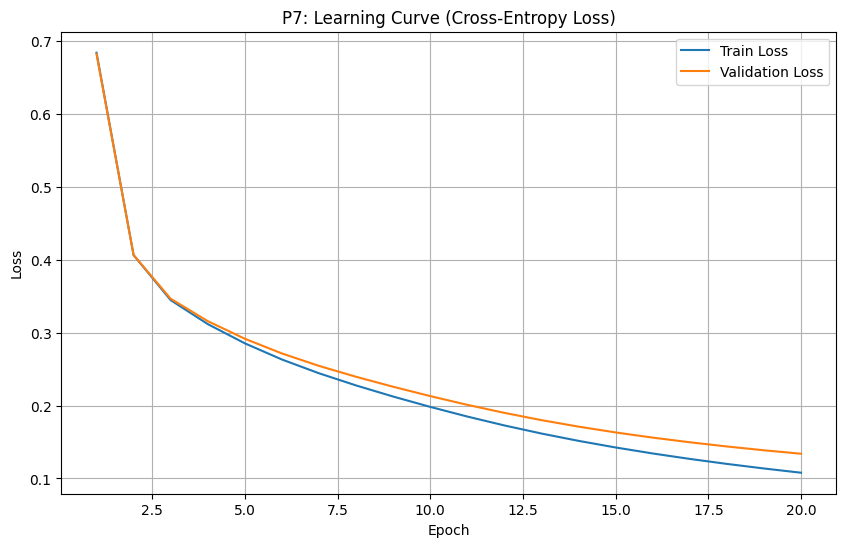

In [9]:

nn_classifier = ScratchSimpleNeuralNetrowkClassifier(
    n_features=784,
    n_nodes1=400,
    n_nodes2=200,
    n_output=10,
    lr=0.01,
    sigma=0.01,
    n_epoch=20,
    batch_size=20,
    verbose=True
)

print("\n--- P6: 学習開始 ---")
nn_classifier.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)
print("--- 学習完了 ---")


y_pred_val = nn_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)

print(f"\n✅ P6: 検証データ Accuracy: {accuracy:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, nn_classifier.n_epoch + 1), nn_classifier.loss['train'], label='Train Loss')
plt.plot(range(1, nn_classifier.n_epoch + 1), nn_classifier.loss['val'], label='Validation Loss')
plt.title('P7: Learning Curve (Cross-Entropy Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:

def plot_misclassified_images(y_pred, y_val, X_val, num=36):


    true_false = y_pred == y_val
    false_list = np.where(true_false == False)[0].astype(np.int64)

    if false_list.shape[0] < num:
        num = false_list.shape[0]

    print(f"\n--- P8: 誤分類された画像 {num} 枚を表示 ---")
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)


    X_val_reshaped = X_val.reshape(-1, 28, 28)

    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])

        ax.set_title(f"{y_pred[false_list[i]]} / {y_val[false_list[i]]}", fontsize=10)
        ax.imshow(X_val_reshaped[false_list[i]], cmap='gray')
    plt.show()


